# Лабораторная работа №7 (Проведение исследований моделями семантической сегментации)
## Выполнил студент группы М8О-406Б-21, Орусский В.Р.

### Выбор исходных данных и обоснование

При выполнении данной ЛР использовался датасет [BDD100K](https://www.kaggle.com/datasets/solesensei/solesensei_bdd100k/), аннотирующий изображения для автомобилей с автопилотом. 

Предназначен для различия объектов на дороге, среди которых выделение тротуаров, дорожных знаков, автомобилей и других различных объектов на дорогах общего пользования. В данном датасете собраны видео с дорожной обстановкой, каждое в среднем по 40 секунд с частотой кадров 30fps (то есть 1200 кадров на видео), снято в разрешении 720p (1280x720px). Помимо этого, в датасет включены данные с GPS, чтобы показать примерную траекторию движения. Датасет охватывает различные погодные условия и времена суток (день / ночь).

Датасет выбран для задачи определения объектов в дорожной обстановке, нужно для создания автопилота (продвинутого круиз-контроля).

### Импорт библиотек

In [1]:
# Data process
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# AI
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

# Computer Vision
from PIL import Image
import cv2
#import albumentations as A


# utils 
import time
import os
from tqdm.notebook import tqdm
from pathlib import Path


In [2]:
%pip install -q segmentation-models-pytorch
%pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


d:\Slavik\Coding\PycharmProjects\Multimedia\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загружаем открытый датасет с помощью `kagglehub`. Сохраняем путь сохранения изображений для дальнейшей работы с выборками

In [3]:
import kagglehub

path = kagglehub.dataset_download("solesensei/solesensei_bdd100k")
path = os.path.join(path, 'bdd100k_seg/bdd100k/seg')

print("Path to auto dataset:", path)

Path to auto dataset: C:\Users\slava\.cache\kagglehub\datasets\solesensei\solesensei_bdd100k\versions\2\bdd100k_seg/bdd100k/seg


In [4]:
TRAIN_IMAGES = os.path.join(path, 'images/train')
TRAIN_MASKS = os.path.join(path, 'labels/train')

VAL_IMAGES = os.path.join(path, 'images/val')
VAL_MASKS = os.path.join(path, 'labels/val')

def check_path(path_name: str):
    if not os.path.exists(path_name):
        raise Exception(f"Пути {path_name} не существует")

check_path(TRAIN_IMAGES)
check_path(TRAIN_MASKS)
check_path(VAL_IMAGES)
check_path(VAL_MASKS)

### Размеры выборки

In [5]:
TRAIN_IMAGES_LIST = os.listdir(TRAIN_IMAGES)
TRAIN_MASKS_LIST = os.listdir(TRAIN_MASKS)

VAL_IMAGES_LIST = os.listdir(VAL_IMAGES)
VAL_MASKS_LIST = os.listdir(VAL_MASKS)

assert len(TRAIN_IMAGES_LIST) == len(TRAIN_MASKS_LIST)
assert len(VAL_IMAGES_LIST) == len(VAL_MASKS_LIST)

print("Размер тренировочной выборки:", len(TRAIN_IMAGES_LIST))
print("Размер валидационной выборки:", len(VAL_IMAGES_LIST))

Размер тренировочной выборки: 7000
Размер валидационной выборки: 1000


Создаём класс для работы с датасетом. Хранение, трансформация и получение файлов из датасета

In [6]:
class BDD100KDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        mask = np.array(mask)
        mask = torch.from_numpy(mask).long()
        return image, mask

Функция для отображения примеров изображения и маски из датасета

In [7]:
def show_images(dataset: BDD100KDataset, cnt_images: int = 5):
    plt.figure(figsize=(14, 5 * cnt_images))

    for idx in range(cnt_images):
        image, mask = dataset[idx]

        plt.subplot(cnt_images, 2, idx * 2 + 1)
        plt.imshow(image)
        plt.title(f'Изображение {idx}')

        plt.subplot(cnt_images, 2, idx * 2 + 2)
        plt.imshow(np.array(mask).squeeze())
        plt.title(f'Маска {idx}')

    plt.tight_layout()
    plt.show()

C:\Users\slava\AppData\Local\Temp\ipykernel_6096\2077722342.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plt.imshow(np.array(mask).squeeze())


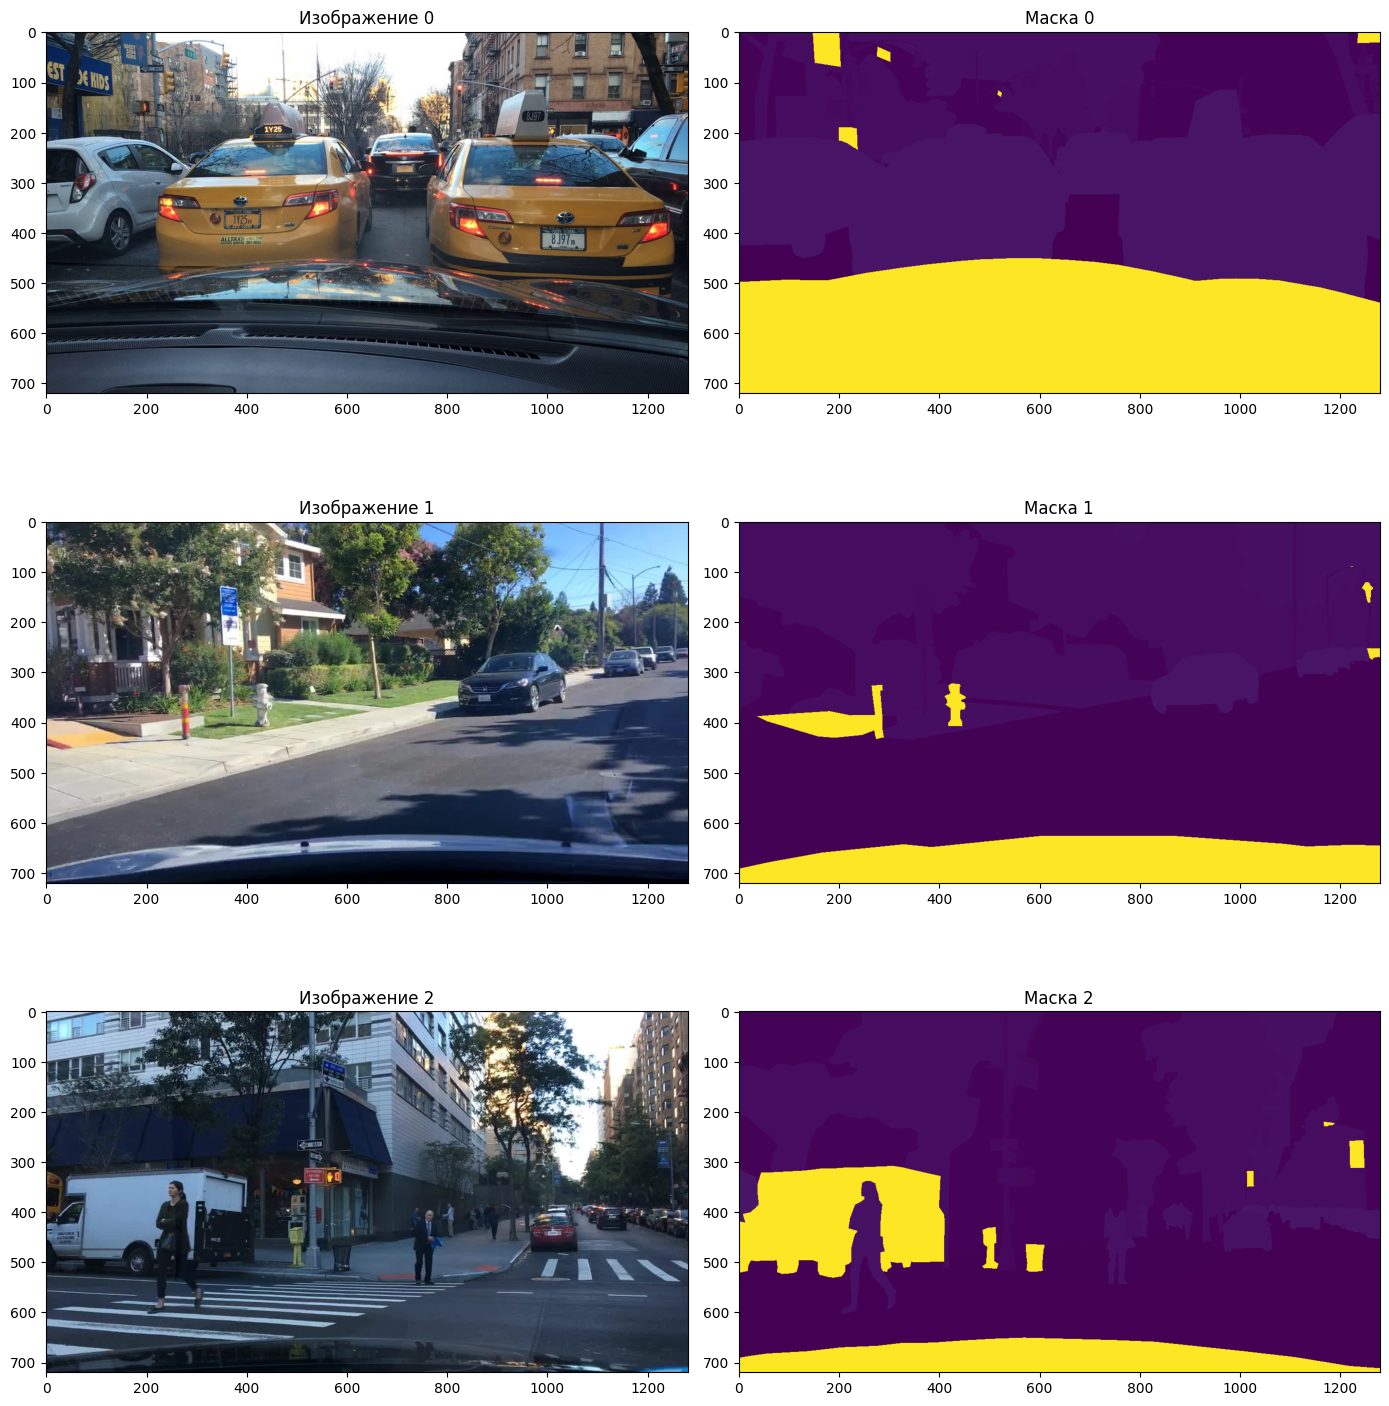

In [8]:
preview_dataset = BDD100KDataset(TRAIN_IMAGES, TRAIN_MASKS, transform=None, mask_transform=None)
show_images(preview_dataset, cnt_images=3)

Аугментация данных. Производим детерменированные изменения, поэтому синхронность необязательна

In [9]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST)
])

Создание датасетов для обучения и валидации, загрузка их в лоадеры

In [10]:
BATCH_SIZE = 8

train_dataset = BDD100KDataset(TRAIN_IMAGES, TRAIN_MASKS, transform=image_transform, mask_transform=mask_transform)
val_dataset = BDD100KDataset(VAL_IMAGES, VAL_MASKS, transform=image_transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Фукнция для оценки сегментации (Accuracy, mIoU, Dice)

In [11]:
NUM_CLASSES = 19 # кол-во классов сегментации

def calculate_metrics(outputs, masks, num_classes):
    with torch.no_grad():
        preds = torch.argmax(outputs, dim=1)

        correct = (preds == masks).float()
        accuracy = correct.sum() / correct.numel()

        ious = []
        dices = []
        for cls in range(num_classes):
            pred_inds = (preds == cls)
            target_inds = (masks == cls)

            intersection = (pred_inds & target_inds).sum().float()
            union = (pred_inds | target_inds).sum().float()
            iou = intersection / union if union > 0 else torch.tensor(1.0)

            dice = 2 * intersection / (pred_inds.sum().float() + target_inds.sum().float()) if (pred_inds.sum() + target_inds.sum()) > 0 else torch.tensor(1.0)

            ious.append(iou)
            dices.append(dice)

        mean_iou = torch.stack(ious).mean()
        mean_dice = torch.stack(dices).mean()

    return accuracy.item(), mean_iou.item(), mean_dice.item()

Функция создания модели

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_classes, num_epochs=10):
    model = model.to(device)
    best_miou = 0.0  # Для сохранения лучшей модели

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_acc_sum = 0
        train_iou_sum = 0
        train_dice_sum = 0
        train_batches = 0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)  # Маски уже [batch, H, W] в BDD100KDataset

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc, iou, dice = calculate_metrics(outputs, masks, num_classes)
            train_acc_sum += acc
            train_iou_sum += iou
            train_dice_sum += dice
            train_batches += 1

        avg_train_loss = train_loss / train_batches
        avg_train_acc = train_acc_sum / train_batches
        avg_train_iou = train_iou_sum / train_batches
        avg_train_dice = train_dice_sum / train_batches

        model.eval()
        val_loss = 0
        val_acc_sum = 0
        val_iou_sum = 0
        val_dice_sum = 0
        val_batches = 0

        with torch.no_grad():
            for images_val, masks_val in val_loader:
                images_val = images_val.to(device)
                masks_val = masks_val.to(device)  # Маски уже [batch, H, W]

                outputs_val = model(images_val)
                loss_val = criterion(outputs_val, masks_val)

                val_loss += loss_val.item()
                acc_val, iou_val, dice_val = calculate_metrics(outputs_val, masks_val, num_classes)
                val_acc_sum += acc_val
                val_iou_sum += iou_val
                val_dice_sum += dice_val
                val_batches += 1

        avg_val_loss = val_loss / val_batches
        avg_val_acc = val_acc_sum / val_batches
        avg_val_iou = val_iou_sum / val_batches
        avg_val_dice = val_dice_sum / val_batches

        print(f"- Эпоха {epoch+1} -")
        print(f"*Train* Loss: {avg_train_loss:.3f} Acc: {avg_train_acc:.3f} IoU: {avg_train_iou:.3f} Dice: {avg_train_dice:.3f}")
        print(f"*Val* Loss: {avg_val_loss:.3f} Acc: {avg_val_acc:.3f} IoU: {avg_val_iou:.3f} Dice: {avg_val_dice:.3f}\n")

        # Сохранение лучшей модели по mIoU
        if avg_val_iou > best_miou:
            best_miou = avg_val_iou
            torch.save(model.state_dict(), 'best_model.pth')

    return {
        'Accuracy': avg_val_acc,
        'mIoU': avg_val_iou,
        'Dice': avg_val_dice
    }

Конфигурация устройства

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Базовая модель и её обучение

In [ ]:
baseline_model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=NUM_CLASSES
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

In [ ]:
print("Обучение базовой модели U-Net...")
baseline_metrics = train_model(baseline_model, criterion, optimizer, train_loader, val_loader, device, NUM_CLASSES, num_epochs=10)
print("Метрики базовой модели:", baseline_metrics)

Улучшение бейзлайна

In [ ]:
improved_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_improved = BDD100KDataset(TRAIN_IMAGES, TRAIN_MASKS, transform=improved_transform, mask_transform=mask_transform)
train_loader_improved = DataLoader(train_dataset_improved, batch_size=8, shuffle=True, num_workers=4)

improved_model = smp.DeepLabV3Plus(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=NUM_CLASSES
).to(device)

optimizer_improved = torch.optim.Adam(improved_model.parameters(), lr=0.0005)

Обучение улучшенной модели

In [ ]:
print("Обучение улучшенной модели DeepLabV3+...")
improved_metrics = train_model(improved_model, criterion, optimizer_improved, train_loader_improved, val_loader, device, NUM_CLASSES, num_epochs=10)
print("Метрики улучшенной модели:", improved_metrics)

Сравнение моделей

In [ ]:
print("Сравнение базовой и улучшенной моделей:")
print(f"Базовая Accuracy: {baseline_metrics['Accuracy']:.4f}, Улучшенная Accuracy: {improved_metrics['Accuracy']:.4f}")
print(f"Базовая mIoU: {baseline_metrics['mIoU']:.4f}, Улучшенная mIoU: {improved_metrics['mIoU']:.4f}")
print(f"Базовая Dice: {baseline_metrics['Dice']:.4f}, Улучшенная Dice: {improved_metrics['Dice']:.4f}")

Собственная модель U-net

In [ ]:
class CustomUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=NUM_CLASSES):
        super(CustomUNet, self).__init__()
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.bottleneck = conv_block(256, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        
        bottleneck = self.bottleneck(self.pool(enc3))
        
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.final_conv(dec1)

Обучение собственной модели

In [ ]:
custom_model = CustomUNet(in_channels=3, out_channels=NUM_CLASSES).to(device)
optimizer_custom = torch.optim.Adam(custom_model.parameters(), lr=0.001)

In [ ]:
print("Обучение собственной модели U-Net...")
custom_metrics = train_model(custom_model, criterion, optimizer_custom, train_loader, val_loader, device, NUM_CLASSES, num_epochs=10)
print("Метрики собственной модели:", custom_metrics)

Улучшенная собственная модель

In [ ]:
custom_model_improved = CustomUNet(in_channels=3, out_channels=NUM_CLASSES).to(device)
optimizer_custom_improved = torch.optim.Adam(custom_model_improved.parameters(), lr=0.0005)

In [ ]:
print("Обучение улучшенной собственной модели U-Net...")
custom_improved_metrics = train_model(custom_model_improved, criterion, optimizer_custom_improved, train_loader_improved, val_loader, device, NUM_CLASSES, num_epochs=10)
print("Метрики улучшенной собственной модели:", custom_improved_metrics)